In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [4]:
from sqlalchemy import func

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
engine.execute('select * from measurement LIMIT 3').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0)]

In [12]:
engine.execute('select * from station LIMIT 3').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)]

In [13]:
# Check columns of table measurement
inspector = inspect(engine)
mm = inspector.get_columns('measurement')

for m in mm:
    print(m['name'],m['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis
* start date and end date for my trip:
2018-07-07 to 2018-07-17

In [14]:
# check last date in measurement table
# Calculate the date 1 year ago from the last data point in the database

engine.execute('SELECT date FROM measurement ORDER BY date DESC limit 1 ').fetchall()

[('2017-08-23',)]

In [15]:
# Check columns of table station
ss = inspector.get_columns('station')

for s in ss:
    print(s['name'],s['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [16]:
# Perform a query to retrieve the data and precipitation scores
# query the last12 months prcp data with date 
lastyr_list  = session.query(Measurement.date, Measurement.prcp).\
   filter(Measurement.date > '2016-08-23' ).all()

In [17]:
## Save the query results as a Pandas DataFrame and set the index to the date column
#Turn list results to DataFrame
df = pd.DataFrame(lastyr_list) 
df.set_index('date',inplace=True)
df.head()

,prcp
date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01


In [18]:
# Check cleaning data done
df.count()

prcp    2015
dtype: int64

In [19]:
df1 = df.groupby('date').mean().copy()

In [20]:
df1.head()

,prcp
date,
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000
2016-08-28,0.516667


In [21]:
# Sort the dataframe by date
df1.sort_values(by=['date'], inplace=True)
df1.head()

,prcp
date,
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000
2016-08-28,0.516667


<Figure size 432x288 with 0 Axes>

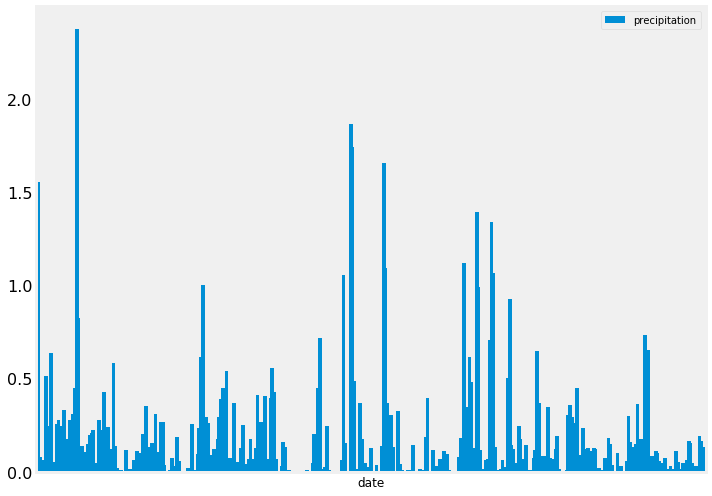

In [22]:
# Use Pandas Plotting with Matplotlib to plot the data# Use Pandas Plotting with Matplotlib to plot the data
plt.figure()
df1.plot(kind = "bar", figsize=(10,7), fontsize = 16, width = 2)
plt.legend(["precipitation"], loc = "best")

plt.xticks([])
plt.grid()
plt.tight_layout()
plt.savefig("precipitation_of_last_12months.png")
plt.show()

In [23]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df1.describe()

,prcp
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


In [24]:
df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [25]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement.station).distinct().count()
stations

9

In [26]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_cnt = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
station_cnt

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [27]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
low = session.query(func.min(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()
high = session.query(func.max(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()
average = session.query(func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()
print(low,high,average)

[(54.0,)] [(85.0,)] [(71.66378066378067,)]


In [28]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
wanted_station = session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc())
print(wanted_station[0])

('USC00519281', 2772)


In [29]:
temp_lastyr = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date > '2016-08-23' ).all()
temp_lastyr_df = pd.DataFrame(temp_lastyr)

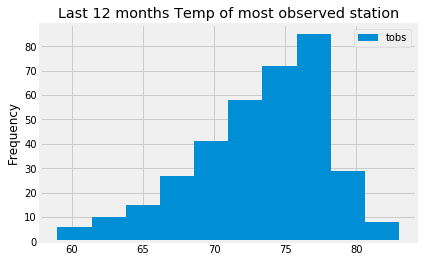

In [30]:
plt.hist(temp_lastyr_df['tobs'])
plt.title('Last 12 months Temp of most observed station')
# plt.xlabel('xx')
plt.ylabel('Frequency')
plt.legend(["tobs"], loc = "best")
plt.savefig("temp_of_last_12months.png")
plt.show()

In [31]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [32]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# 2017-07-07 to 2017-07-17

print(calc_temps('2017-07-07', '2017-07-17'))

[(69.0, 78.15492957746478, 82.0)]


In [33]:
labels = ['TMIN', 'TAVG', 'TMAX']
df_bar = pd.DataFrame(calc_temps('2017-07-07', '2017-07-17'), columns=labels)

df_bar

,TMIN,TAVG,TMAX
0,69.0,78.15493,82.0


In [34]:
a = df_bar['TMIN']
b = df_bar['TMAX']

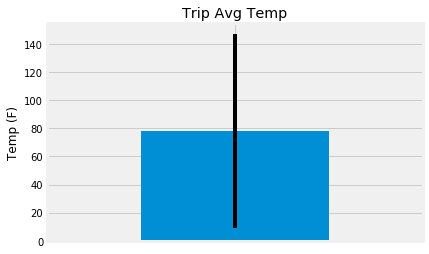

In [35]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

error = [a, b]

plt.figure()
df_bar['TAVG'].plot(kind = "bar", yerr = error)
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")

# Remove x axis ticks
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

# Save image
plt.savefig("Trip Avg Temp.png")
plt.show()

In [36]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

from sqlalchemy import and_

rainfall = session.query(Measurement.station, func.sum(Measurement.prcp), Station.name, Station.latitude,  Station.longitude,  Station.elevation).\
    filter(and_(Measurement.date>'2017-07-07', Measurement.date<'2017-07-17')).\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()

In [37]:
rainfall

[('USC00516128',
  18.449999999999996,
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0),
 ('USC00519281',
  9.900000000000007,
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0),
 ('USC00513117',
  5.490000000000004,
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0),
 ('USC00514830',
  4.589999999999998,
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0),
 ('USC00519397',
  0.9900000000000004,
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0),
 ('USC00519523', 0.99, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00517948', None, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)]

In [38]:
from datetime import timedelta, date

def daterange(date1, date2):
    for n in range(int((date2 - date1).days+1)):
        yield date1 + timedelta(n)
        
start_date = date(2017,7,7)
end_date = date(2017,7,17)

dtlist =[]

for dt in daterange(start_date, end_date):
#     print(dt.strftime("20%y-%m-%d"))
        dtlist.append(dt.strftime("20%y-%m-%d"))

dtlist

['2017-07-07',
 '2017-07-08',
 '2017-07-09',
 '2017-07-10',
 '2017-07-11',
 '2017-07-12',
 '2017-07-13',
 '2017-07-14',
 '2017-07-15',
 '2017-07-16',
 '2017-07-17']

## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
